# Variational Quantum Circuit
In this notebook we work to try and use Qiskit's [VQC class](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) in order to make a circuit that can classify binary data.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, GradientDescent, P_BFGS, QNSPSA, SPSA
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import statistics

algorithm_globals.random_seed = 0
np.random.seed(0)

## Set Constants

In [88]:
num_train = 50 # Number of training instances to use
num_folds = 3 # Number of folds to use in k-fold validation

## Importing the data

In [2]:
# Import the HTRU pulsar data
data = np.loadtxt('../datasets/HTRU_2.csv', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Limit x to be an equal amount of both classes
ind = y == 0
x_0 = x[ind][:num_train]
y_0 = y[ind][:num_train]
ind = y == 1
x_1 = x[ind][:num_train]
y_1 = y[ind][:num_train]
x = np.concatenate((x_0, x_1))
y = np.concatenate((y_0, y_1))

# Split data into training set and testing set
sample_train_pulsar, sample_test_pulsar, label_train_pulsar, label_test_pulsar = train_test_split(x, y, shuffle=True, stratify=y, train_size=0.5) 

# Normalize the data
sample_train_pulsar = normalize(sample_train_pulsar)
sample_test_pulsar = normalize(sample_test_pulsar)

In [48]:
## Import the gamma telescope data
data = np.loadtxt('../datasets/magic04.data', delimiter=',', skiprows=1)
[n,p] = np.shape(data)

x = data[:, 0:-1]
y = data[:, -1]

# Limit x to be an equal amount of both classes
ind = y == 0
x_0 = x[ind][:num_train]
y_0 = y[ind][:num_train]
ind = y == 1
x_1 = x[ind][:num_train]
y_1 = y[ind][:num_train]
x = np.concatenate((x_0, x_1))
y = np.concatenate((y_0, y_1))

# Split data into training set and testing set
sample_train_gamma, sample_test_gamma, label_train_gamma, label_test_gamma = train_test_split(x, y,shuffle=True, train_size=0.5) 

# Normalize the data
sample_train_gamma = normalize(sample_train_gamma)
sample_test_gamma = normalize(sample_test_gamma)

## Create the Variational Circuit
For our inital circuit, we will use cnot gates as out entangling layer, and we will start with just rz gates. We will have a cnot gate connect between every adjacent gate similar to one of the examples of entangling layers given in [this paper](https://arxiv.org/abs/2206.02806)

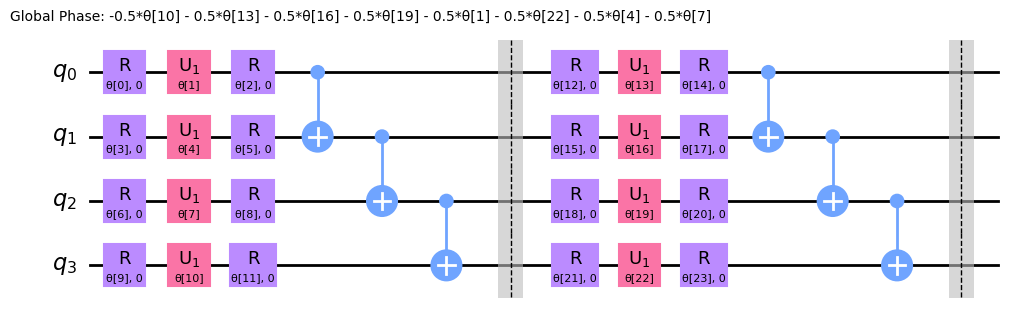

In [4]:
# Create a function so we can easily create new circuits
def cnot_rxzx_circuit(num_inputs, num_layers):
    num_parameters = num_inputs * num_layers * 3
    x = ParameterVector("θ", length=num_parameters)
    circuit = QuantumCircuit(num_inputs)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_inputs):
            circuit.rx(x[layer*num_inputs*3 + 3*i], i)
            circuit.rz(x[layer*num_inputs*3 + 3*i + 1], i)
            circuit.rx(x[layer*num_inputs*3 + 3*i + 2], i)
        #Create the entangling layer
        for i in range(num_inputs - 1):
            circuit.cx(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cnot_rxzx_circuit(4, 2)
circuit.decompose().draw('mpl')

In [49]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title(f"Objective function value against iteration {len(layer_train_accuracy)}")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Train on Pulsar Dataset

### Reduce the number of features

In [99]:
pca = PCA(n_components=3) # 3 features is minimum number of features that achieved same classical performance as using all features
pca.fit(sample_train_pulsar)
X_train = pca.transform(sample_train_pulsar)
X_test = pca.transform(sample_test_pulsar)
Y_train = label_train_pulsar
Y_test = label_test_pulsar

### Classical Model

In [98]:
# Average the accuracy over num_folds runs of SVM
test_errors = []
train_errors = []
kf = KFold(n_splits=num_folds)
for train, test in kf.split(X_test):
    x_train, x_test, y_train, y_test = X_train[train], X_train[test], Y_train[train], Y_train[test]
    
    #Create a svm Classifier
    model = svm.SVC(kernel='rbf', gamma='scale') # RBF Kernel
    
    #Train the model using the training sets
    model.fit(x_train, y_train)
    
    #Predict the response for test dataset
    predictions_train = model.predict(x_train)
    predictions_test = model.predict(x_test)
    
    # evaluate model error
    error_train = 1 - accuracy_score(y_train, predictions_train)
    error_test = 1 - accuracy_score(y_test, predictions_test)
    test_errors.append(error_test)
    train_errors.append(error_train)

print(f"Test Error: {np.mean(test_errors):.3}, Train Error: {np.mean(train_errors):.3}")

Test Error: 0.14, Train Error: 0.11


### Train and vary number of layers

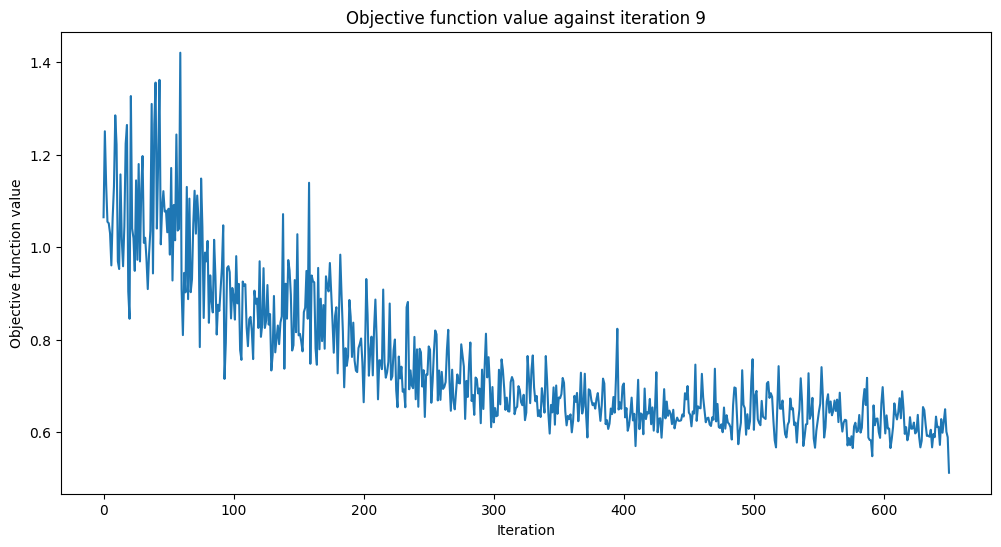

In [101]:
# Vary the number of layers
num_layers_to_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
layer_train_accuracy = []
layer_test_accuracy = []
for num_layers in num_layers_to_test:
    # Use n-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    kf = KFold(n_splits=num_folds)
    for train, test in kf.split(X_test):
        x_train, x_test, y_train, y_test = X_test[train], X_test[test], Y_test[train], Y_test[test]
    
        num_inputs = len(x_train[0])
        
        # construct feature map, ansatz, and optimizer
        feature_map = ZZFeatureMap(num_inputs)
        ansatz = cnot_rxzx_circuit(num_inputs, num_layers)
        initial_point = np.random.rand(3*num_inputs*num_layers)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=300),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(x_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(x_train, y_train)
        testing_error = 1 - vqc.score(x_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the k folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [103]:
#Save the training results to a dataframe
data = {'Layers': num_layers_to_test,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

pulsar_data = pd.DataFrame(data)
pulsar_data.to_pickle('pulsar_vary_layers.pkl')

pulsar_data

,Layers,Training Error,Testing Error
0,1,0.369875,0.460784
1,2,0.270053,0.480392
2,3,0.130422,0.360294
3,4,0.140226,0.280637
4,5,0.140523,0.338235
5,6,0.130125,0.340686
6,7,0.130125,0.261029
7,8,0.150030,0.340686
8,9,0.130125,0.300245
9,10,0.129828,0.300245


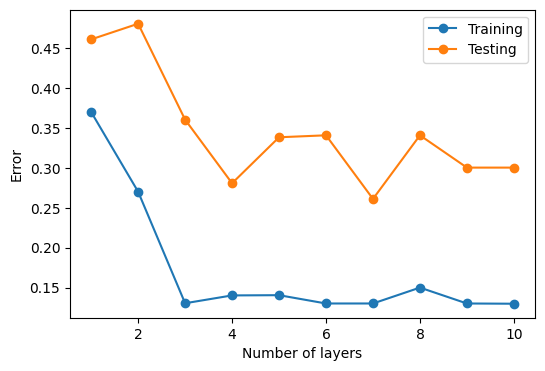

In [104]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Number of layers")
ax.set_ylabel("Error")
ax.plot(pulsar_data['Layers'], pulsar_data['Training Error'], marker='o', label="Training")
ax.plot(pulsar_data['Layers'], pulsar_data['Testing Error'], marker='o', label="Testing")
ax.legend()

## Vary encoding layers

### Vary repetitions of ZZ feature map

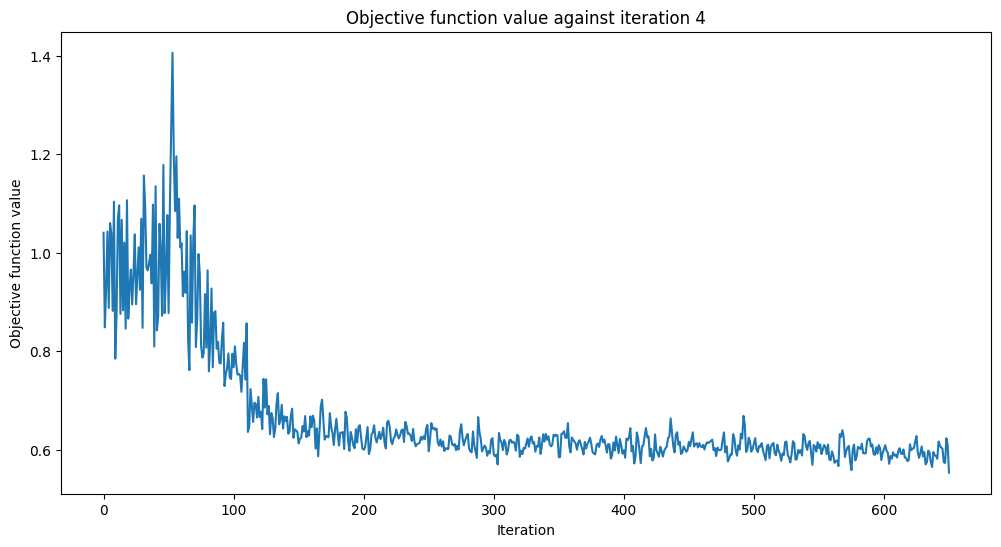

In [115]:
# Vary the number of layers
num_reps = [1, 2, 3, 4, 5]
layer_train_accuracy = []
layer_test_accuracy = []
for reps in num_reps:
    # Use n-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    kf = KFold(n_splits=num_folds)
    for train, test in kf.split(X_test):
        x_train, x_test, y_train, y_test = X_test[train], X_test[test], Y_test[train], Y_test[test]
    
        num_inputs = len(x_train[0])
        
        # construct feature map, ansatz, and optimizer
        feature_map = ZZFeatureMap(num_inputs, reps=reps)
        ansatz = cnot_rxzx_circuit(num_inputs, 4)
        initial_point = np.random.rand(3*num_inputs*4)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=300),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(x_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(x_train, y_train)
        testing_error = 1 - vqc.score(x_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the k folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [116]:
#Save the training results to a dataframe
data = {'Repetitions': num_reps,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

pulsar_ZZ_data = pd.DataFrame(data)
pulsar_ZZ_data.to_pickle('pulsar_vary_ZZ_reps.pkl')

pulsar_ZZ_data

,Repetitions,Training Error,Testing Error
0,1,0.109923,0.159314
1,2,0.149733,0.341912
2,3,0.120321,0.202206
3,4,0.120618,0.321078
4,5,0.130719,0.220588


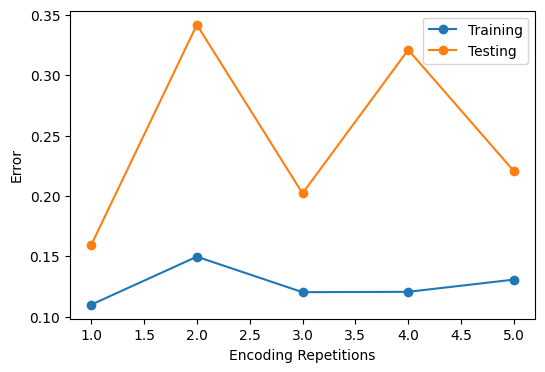

In [117]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Encoding Repetitions")
ax.set_ylabel("Error")
ax.plot(pulsar_ZZ_data['Repetitions'], pulsar_ZZ_data['Training Error'], marker='o', label="Training")
ax.plot(pulsar_ZZ_data['Repetitions'], pulsar_ZZ_data['Testing Error'], marker='o', label="Testing")
ax.legend()

### Block Based encoding

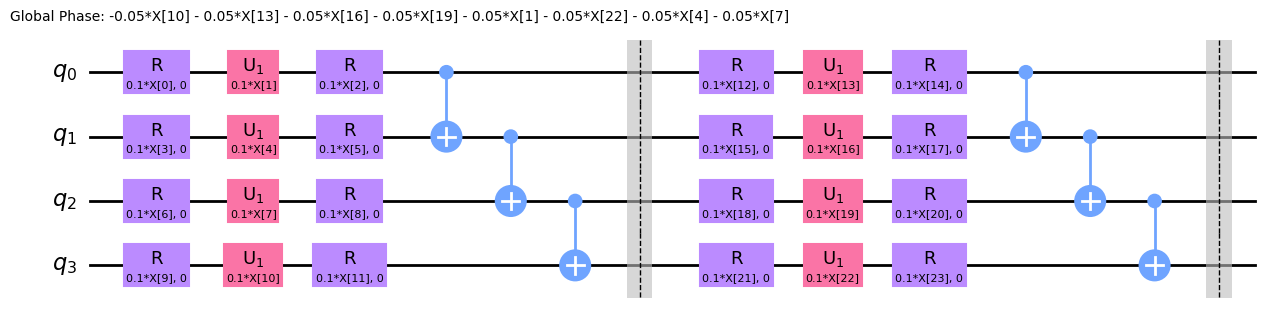

In [147]:
# Create a function so we can easily create new circuits
def cnot_rxzx_encoding(num_qubits, num_layers, c):
    num_parameters = num_qubits * num_layers * 3
    x = ParameterVector("X", length=num_parameters)
    circuit = QuantumCircuit(num_qubits)
    
    #Create the processing blocks
    for layer in range(num_layers):
        #Create the parameterized gates
        for i in range(num_qubits):
            circuit.rx(x[layer*num_qubits*3 + 3*i]*c, i)
            circuit.rz(x[layer*num_qubits*3 + 3*i + 1]*c, i)
            circuit.rx(x[layer*num_qubits*3 + 3*i + 2]*c, i)
        #Create the entangling layer
        for i in range(num_qubits - 1):
            circuit.cx(i,i+1)
        circuit.barrier()
        
    return circuit

# Draw an example of the ciruit
circuit = cnot_rxzx_encoding(4, 2, 0.1)
circuit.decompose().draw('mpl')

In [141]:
# Add a zero to all samples since we will be using 9 inputs
temp = np.zeros((len(sample_train_pulsar), 1))
X_train = np.hstack((sample_train_pulsar, temp))
temp = np.zeros((len(sample_test_pulsar), 1))
X_test = np.hstack((sample_test_pulsar, temp))

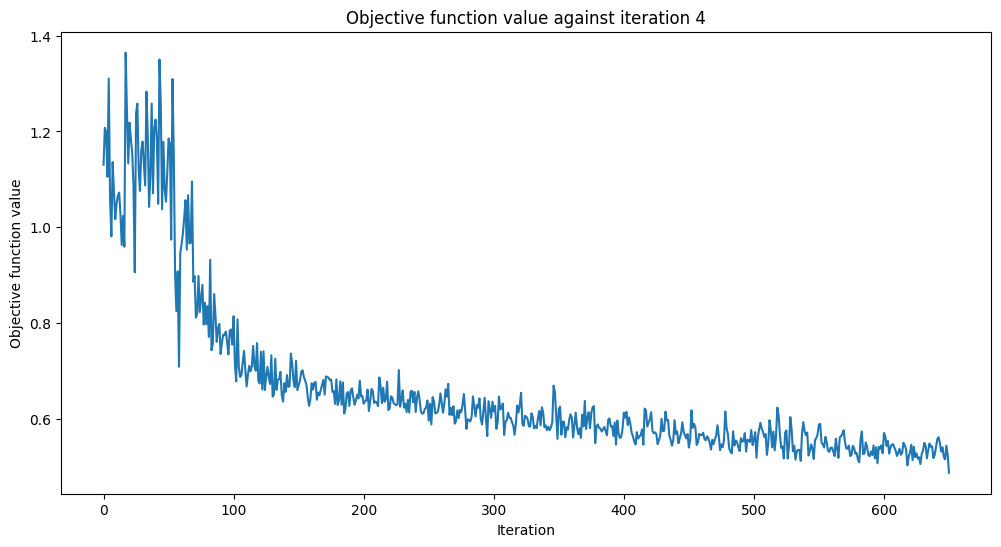

In [150]:
# Vary the number of layers
c_to_test = [0.1, 0.5, 1, 5, 10]
layer_train_accuracy = []
layer_test_accuracy = []
for c in c_to_test:
    # Use n-fold cross validation to get more consistent results
    training_errors = []
    testing_errors = []
    kf = KFold(n_splits=num_folds)
    for train, test in kf.split(X_test):
        x_train, x_test, y_train, y_test = X_test[train], X_test[test], Y_test[train], Y_test[test]
    
        num_inputs = int(len(x_train[0]) / 3)
        
        # construct feature map, ansatz, and optimizer
        feature_map = cnot_rxzx_encoding(3, 1, c)
        ansatz = cnot_rxzx_circuit(num_inputs, 4)
        initial_point = np.random.rand(3*num_inputs*4)
        
        # construct variational quantum classifier
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            loss="cross_entropy",
            optimizer= SPSA(maxiter=300),
            callback=callback_graph,
            initial_point=initial_point
        )
        
        # create empty array for callback to store evaluations of the objective function
        objective_func_vals = []
        plt.rcParams["figure.figsize"] = (12, 6)
        
        # fit classifier to data
        vqc.fit(x_train, y_train)
        
        # return to default figsize
        plt.rcParams["figure.figsize"] = (6, 4)
    
        # score classifier
        training_error = 1 - vqc.score(x_train, y_train)
        testing_error = 1 - vqc.score(x_test, y_test)
        training_errors.append(training_error)
        testing_errors.append(testing_error)
    
    # Find the average error from the k folds
    average_train_error = np.mean(training_errors)
    average_test_error = np.mean(testing_errors)
    layer_train_accuracy.append(average_train_error)
    layer_test_accuracy.append(average_test_error)

In [152]:
#Save the training results to a dataframe
data = {'Scaling Factor': c_to_test,
        'Training Error':layer_train_accuracy,
        'Testing Error': layer_test_accuracy}

pulsar_block_data = pd.DataFrame(data)
pulsar_block_data.to_pickle('pulsar_vary_block_scaling.pkl')

pulsar_block_data

,Scaling Factor,Training Error,Testing Error
0,0.1,0.449792,0.599265
1,0.5,0.290850,0.355392
2,1.0,0.150327,0.139706
3,5.0,0.120024,0.140931
4,10.0,0.150327,0.301471


In [ ]:
#Plot the results
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel("Scaling Fac")
ax.set_ylabel("Error")
ax.plot(pulsar_ZZ_data['Repetitions'], pulsar_ZZ_data['Training Error'], marker='o', label="Training")
ax.plot(pulsar_ZZ_data['Repetitions'], pulsar_ZZ_data['Testing Error'], marker='o', label="Testing")
ax.legend()